In [4]:
import emnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import methods as M
import sklearn
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.layers import Input, Lambda, Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
%matplotlib inline

In [45]:
train_images, train_labels, oneshot_images, oneshot_labels, classify_images, classify_labels = M.get_emnist(40, 1, True, False)

======= Loading emnist data ... =======
Output shape:  [(96000, 28, 28), (96000,), (16800, 28, 28), (16800,)]
Train labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 18 19 22 24 25 26 27 28
 29 30 32 33 34 35 36 37 38 40 41 42 43 44 45 46]
Test labels:  [14 17 20 21 23 31 39]
======= Finished loading. =======


In [34]:
def get_image_by_label(label):
    return train_images[np.random.choice(np.where(train_labels == label)[0], 1, False)[0]]

In [60]:
def get_train_data(size):
    targets = np.zeros((size,))
    targets[size//2:] = 1
    pairs = [np.zeros((size, 28, 28)) for _ in range(2)]
    labels = np.unique(train_labels)
    for i in range(size):
        class1 = np.random.choice(labels, 1)[0]
        class2 = class1
        if i < size//2:
            while class2 == class1:
                class2 = np.random.choice(labels, 1)[0]
        pairs[0][i] = get_image_by_label(class1)
        pairs[1][i] = get_image_by_label(class2)
    return pairs, targets

In [6]:
def get_siamese_net_and_encoder(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    encoder = Sequential()
    encoder.add(Conv2D(16, (3, 3), input_shape=input_shape, activation='relu', kernel_regularizer='l2'))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    encoder.add(MaxPooling2D(pool_size=2, strides=(2, 2)))
    encoder.add(Dropout(0.25))
    
    encoder.add(Conv2D(32, (3, 3), kernel_regularizer='l2'))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    encoder.add(MaxPooling2D(pool_size=2, strides=(2, 2)))
    encoder.add(Dropout(0.25))
    
    encoder.add(Flatten())
    
    encoder.add(Dense(32, activation='sigmoid', kernel_regularizer='l2'))
    
    left_emb = encoder(left_input)
    right_emb = encoder(right_input)
    
    L1_Layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_Dist = L1_Layer([left_emb,right_emb])
    OP = Dense(1, activation='sigmoid', kernel_regularizer='l2')(L1_Dist)
    
    siamese_net = Model(inputs=[left_input, right_input], outputs=OP)
    
    return siamese_net, encoder

In [ ]:
def make_one_shot_task(N):
    labels = np.unique(train_labels)
    cats = np.random.choice(labels, N, replace=False)
    _, w, h = train_images.shape
    true_cat = cats[0]
    test_image = np.array([get_image_by_label(true_cat)]*N).reshape(N, w, h, 1)
    support_set = get_image_by_label(cats).reshape(N, w, h, 1)
    targets = np.zeros((N,))
    targets[0] = 1
    
    test_image,support_set,targets = sklearn.utils.shuffle(test_image,support_set,targets)
    
    return [test_image,support_set], targets

In [73]:
def test_siamese(siamese_net, encoder, similar = None):
    if similar == None: 
        if np.random.rand() < 1/2: return test_siamese(siamese_net, encoder, True)
        else: return test_siamese(siamese_net, encoder, False)
    
    labels = np.unique(train_labels)
    class1 = np.random.choice(labels, 1)[0]
    class2 = class1
    if not similar:
        while class2 == class1:
            class2 = np.random.choice(labels, 1)[0]
    img1 = np.expand_dims(get_image_by_label(class1), axis=2)
    img2 = np.expand_dims(get_image_by_label(class2), axis=2)
    print("======= Testing siamese network ... =======")
    print("Class 1: ", class1)
    print("Class 2: ", class2)
    print("Shape: ", img1.shape)

    f, axes = plt.subplots(1, 2, figsize = (10, 5))
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    axes[0].axis('off')
    axes[1].axis('off')
    
    print("Similarity: ", siamese_net.predict([[img1, img2]]))
    return siamese_net.predict([[img1, img2]])
    
    

In [53]:
num_iterations = 700
batch_size = 10

_, w, h = train_images.shape

siamese_net, encoder = get_siamese_net_and_encoder((w, h, 1))

siamese_net.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

siamese_net.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_12 (Sequential)     (None, 32)           30624       ['input_25[0][0]',               
                                                                  'input_26[0][0]']               
                                                                                                  
 lambda_10 (Lambda)             (None, 32)           0           ['sequential_12[0][0]',   

In [58]:
for i in range(0, num_iterations):
    x, y = get_train_data(batch_size)
    siamese_net.train_on_batch(x, y)

In [59]:
oneshot_images_repr = encoder(oneshot_images)
classify_images_repr = encoder(classify_images)

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(oneshot_images_repr, oneshot_labels)

pred = neigh.predict(classify_images_repr)

print("Accuracy: ", np.sum(pred == classify_labels)/len(classify_labels))

Accuracy:  0.45691657238134936


======= Testing siamese network ... =======
Class 1:  33
Class 2:  33
Shape:  (28, 28, 1)


ValueError: in user code:

    File "C:\Users\bachk_gitmnel\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\bachk_gitmnel\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\bachk_gitmnel\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\bachk_gitmnel\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\bachk_gitmnel\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\bachk_gitmnel\AppData\Roaming\Python\Python310\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_10' (type Functional).
    
    Input 0 of layer "sequential_12" is incompatible with the layer: expected shape=(None, 28, 28, 1), found shape=(None, 28, 1, 1)
    
    Call arguments received by layer 'model_10' (type Functional):
      • inputs=('tf.Tensor(shape=(None, 28, 1), dtype=float32)', 'tf.Tensor(shape=(None, 28, 1), dtype=float32)')
      • training=False
      • mask=None


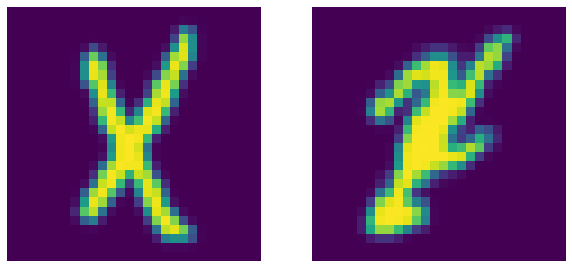

In [74]:
test_siamese(siamese_net, encoder, similar = True)

In [56]:
M.test_CNE(train_images, train_labels, oneshot_images, oneshot_labels, classify_images, classify_labels, 40, 32, True, 1, 28, 28, 1, 28*28)

======= CNN ae method: Training and evaluating ... =======
Learning background ...
Epoch 1/10
3000/3000 [==============================] - 32s 10ms/step - loss: 0.0212
Epoch 2/10
3000/3000 [==============================] - 30s 10ms/step - loss: 0.0130
Epoch 3/10
3000/3000 [==============================] - 29s 10ms/step - loss: 0.0118
Epoch 4/10
3000/3000 [==============================] - 29s 10ms/step - loss: 0.0111
Epoch 5/10
3000/3000 [==============================] - 30s 10ms/step - loss: 0.0107
Epoch 6/10
3000/3000 [==============================] - 29s 10ms/step - loss: 0.0104
Epoch 7/10
3000/3000 [==============================] - 29s 10ms/step - loss: 0.0102
Epoch 8/10
3000/3000 [==============================] - 29s 10ms/step - loss: 0.0100
Epoch 9/10
3000/3000 [==============================] - 29s 10ms/step - loss: 0.0099
Epoch 10/10
3000/3000 [==============================] - 30s 10ms/step - loss: 0.0098
Vectorizing ...
Learning oneshot ...
Predicting ...
Accuracy:  0.4

0.4513785505865539